In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

In [23]:
import sys
import os
import struct
import time
import numpy as np
import h5py
from scipy.stats import pearsonr
from itertools import chain
from scipy.io import loadmat
from tqdm import tqdm
import pickle
import math
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

fpX = np.float32
import src.numpy_utility as pnu
from src.plots import display_candidate_loss
from src.file_utility import save_stuff, flatten_dict, embed_dict
from src.torch_fwrf import get_value, get_predictions

In [3]:
import torch
import torch.nn as nn

print ('#device:', torch.cuda.device_count())
print ('device#:', torch.cuda.current_device())
print ('device name:', torch.cuda.get_device_name(torch.cuda.current_device()))

torch.manual_seed(time.time())
device = torch.device("cuda:0") #cuda
torch.backends.cudnn.enabled=True

print ('\ntorch:', torch.__version__)
print ('cuda: ', torch.version.cuda)
print ('cudnn:', torch.backends.cudnn.version())
print ('dtype:', torch.get_default_dtype())
#torch.set_default_dtype(torch.float64)

#device: 3
device#: 0
device name: TITAN RTX

torch: 1.3.0
cuda:  10.1.243
cudnn: 7603
dtype: torch.float32


In [7]:
subject = 1
timestamp = 'Mar-27-2020_0301'

saveext = ".png"
savearg = {'format':'png', 'dpi': 120, 'frameon': False}

root_dir   = os.getcwd() + '/'
net_dir    = root_dir + "net/" 
output_dir = root_dir+"output/S%02d/" % (subject) 
video_dir = root_dir+"video/"

if not os.path.exists(video_dir):
    os.makedirs(video_dir)
if not os.path.exists(net_dir):
    os.makedirs(net_dir)
if not os.path.exists(output_dir):
    os.makedirs(output_dir)
    
print ("Time Stamp: %s" % timestamp)

Time Stamp: Mar-27-2020_0301


# Load stimuli

In [8]:
nsd_root = "/home/styvesg/repo.data/datasets/nsd/"
stim_root = nsd_root + "nsddata_stimuli/stimuli/nsd/"
beta_root = nsd_root + "nsddata_betas/ppdata/"
mask_root = nsd_root + "nsddata/ppdata/"

exp_design_file = nsd_root + "nsddata/experiments/nsd/nsd_expdesign.mat"
stim_file       = stim_root + "nsd_stimuli.hdf5"

In [9]:
exp_design = loadmat(exp_design_file)
ordering = exp_design['masterordering'].flatten() - 1 # zero-indexed ordering of indices (matlab-like to python-like)

image_data_set = h5py.File(stim_root + "S%d_stimuli_227.h5py"%subject, 'r')
image_data = np.copy(image_data_set['stimuli']).astype(np.float32) / 255.
image_data_set.close()

print (image_data.shape)
print (image_data.dtype)
print (np.min(image_data[0]), np.max(image_data[0]))

(10000, 3, 227, 227)
float32
0.0 1.0


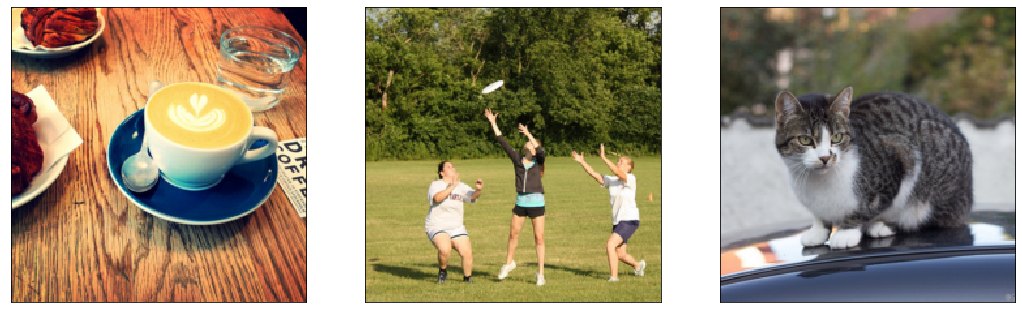

In [10]:
plt.figure(figsize=(18,6))
for i in range(3):
    plt.subplot(1,3,i+1)
    plt.imshow(image_data[6+i].transpose((1,2,0)), cmap='gray', interpolation='None')
    plt.gca().get_xaxis().set_visible(False)
    plt.gca().get_yaxis().set_visible(False)

# Load Voxels

In [11]:
from src.file_utility import load_mask_from_nii, view_data

In [12]:
voxel_r2_full      = load_mask_from_nii(beta_root + "subj%02d/func1pt8mm/betas_fithrf_GLMdenoise_RR/R2.nii.gz"%(subject,))
brain_mask_full    = load_mask_from_nii(mask_root + "subj%02d/func1pt8mm/brainmask.nii.gz"%(subject))
tight_mask_full    = load_mask_from_nii(mask_root + "subj%02d/func1pt8mm/brainmask_inflated_1.0.nii"%subject)
general_mask_full  = load_mask_from_nii(mask_root + "subj%02d/func1pt8mm/roi/nsdgeneral.nii.gz"%(subject))
voxel_roi_full     = load_mask_from_nii(mask_root + "subj%02d/func1pt8mm/roi/Kastner2015.nii.gz"%(subject))

brain_nii_shape = brain_mask_full.shape

brain_mask_full = tight_mask_full.flatten().astype(bool)
voxel_r2_brain  = voxel_r2_full.flatten()[brain_mask_full]
voxel_idx_brain = np.arange(len(brain_mask_full))[brain_mask_full]
voxel_roi_brain = voxel_roi_full.flatten()[brain_mask_full]

general_mask_full = (general_mask_full==1).flatten().astype(bool)
voxel_r2_general  = voxel_r2_full.flatten()[general_mask_full]
voxel_idx_general = np.arange(len(general_mask_full))[general_mask_full]
voxel_roi_general = voxel_roi_full.flatten()[general_mask_full]

## Display a slice of the data

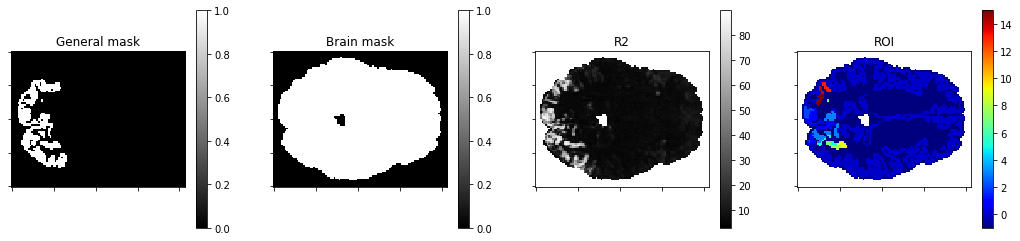

In [13]:
volume_r2         = view_data(voxel_r2_full.shape, voxel_idx_brain, np.nan_to_num(voxel_r2_brain))
volume_general_mask = view_data(voxel_r2_full.shape, np.arange(len(brain_mask_full)), general_mask_full)
volume_brain_mask = view_data(voxel_r2_full.shape, np.arange(len(brain_mask_full)), brain_mask_full)
volume_brain_roi  = view_data(voxel_r2_full.shape, voxel_idx_brain, voxel_roi_brain)

slice_idx = 40
fig = plt.figure(figsize=(18,4))
plt.subplot(1,4,1)
plt.imshow(volume_general_mask[:,:,slice_idx], cmap='gray', interpolation='None')
plt.title('General mask')
plt.colorbar()
_=plt.gca().set_xticklabels([])
_=plt.gca().set_yticklabels([])
plt.subplot(1,4,2)
plt.imshow(volume_brain_mask[:,:,slice_idx], cmap='gray', interpolation='None')
plt.title('Brain mask')
plt.colorbar()
_=plt.gca().set_xticklabels([])
_=plt.gca().set_yticklabels([])
plt.subplot(1,4,3)
plt.imshow(volume_r2[:,:,slice_idx], cmap='gray', interpolation='None')
plt.title('R2')
plt.colorbar()
_=plt.gca().set_xticklabels([])
_=plt.gca().set_yticklabels([])
plt.subplot(1,4,4)
plt.imshow(volume_brain_roi[:,:,slice_idx], cmap='jet', interpolation='None')
plt.title('ROI')
plt.colorbar()
_=plt.gca().set_xticklabels([])
_=plt.gca().set_yticklabels([])

## Select what mask to use

In [14]:
voxel_mask = brain_mask_full
voxel_idx = voxel_idx_brain
voxel_roi = voxel_roi_brain
voxel_r2  = voxel_r2_brain

In [15]:
beta_subj = beta_root + "subj%02d/func1pt8mm/betas_fithrf_GLMdenoise_RR/" % (subject,)

from src.load_nsd import load_betas
voxel_data, filenames = load_betas(folder_name=beta_subj, zscore=True, voxel_mask=voxel_mask, up_to=-1)
print (voxel_data.shape)

/home/styvesg/repo.data/datasets/nsd/nsddata_betas/ppdata/subj01/func1pt8mm/betas_fithrf_GLMdenoise_RR/betas_session01.mat
int16 -32768 32767 (750, 83, 104, 81)
<beta> = 0.113, <sigma> = 0.225
/home/styvesg/repo.data/datasets/nsd/nsddata_betas/ppdata/subj01/func1pt8mm/betas_fithrf_GLMdenoise_RR/betas_session02.mat
int16 -32768 32767 (750, 83, 104, 81)
<beta> = 0.090, <sigma> = 0.200
/home/styvesg/repo.data/datasets/nsd/nsddata_betas/ppdata/subj01/func1pt8mm/betas_fithrf_GLMdenoise_RR/betas_session03.mat
int16 -32768 32767 (750, 83, 104, 81)
<beta> = 0.117, <sigma> = 0.216
/home/styvesg/repo.data/datasets/nsd/nsddata_betas/ppdata/subj01/func1pt8mm/betas_fithrf_GLMdenoise_RR/betas_session04.mat
int16 -32768 32767 (750, 83, 104, 81)
<beta> = 0.089, <sigma> = 0.190
/home/styvesg/repo.data/datasets/nsd/nsddata_betas/ppdata/subj01/func1pt8mm/betas_fithrf_GLMdenoise_RR/betas_session05.mat
int16 -32768 32767 (750, 83, 104, 81)
<beta> = 0.098, <sigma> = 0.214
/home/styvesg/repo.data/datasets/ns

## Voxel grouping and voxel ROI iterator

In [16]:
from src.roi import iterate_roi, roi_map

roi_group_names = ['V1', 'V2', 'V3', 'V4', 'VO', 'PHC', 'MST', 'hMT', 'LO', 'V3a/b', 'IPS', 'All']
roi_group = [[1,2],[3,4],[5,6], [7], [8,9], [10,11], [12], [13], [14,15], [16,17], [18,19,20,21,22,23], np.arange(0,24)]
for roi_mask, roi_name in iterate_roi(roi_group, voxel_roi, roi_map, group_name=roi_group_names):
    print ("%d \t: %s" % (np.sum(roi_mask), roi_name))

2261 	: V1
1681 	: V2
1442 	: V3
462 	: V4
525 	: VO
374 	: PHC
54 	: MST
281 	: hMT
517 	: LO
990 	: V3a/b
2148 	: IPS
106847 	: All


## Reduce the stimulus set to those of which we have responses so far.
- It just so happens that images with index less than 1000 are shared among subjects and are garanteed not to be shown in the remainder. We therefore chose to reparate our training and validation set along these lines.
- We could have reduced the number of voxels already but I needed them for something else at another point.

In [17]:
data_size, nv = voxel_data.shape 
print ("Total number of voxels = %d" % nv)

ordering_data = ordering[:data_size]
shared_mask   = ordering_data<1000  # the first 1000 indices are the shared indices

val_size = np.sum(shared_mask)
trn_size = data_size - val_size
print ("Validation size =", val_size, ", Training size =", trn_size)

Total number of voxels = 238508
Validation size = 3000 , Training size = 27000


In [18]:
## double and triple check that I haven't misaligned the image and responses.
trn_voxel_data = voxel_data[~shared_mask]
val_voxel_data = voxel_data[shared_mask]

stim_data = image_data[ordering_data]  # reduce to only the samples available thus far

trn_stim_data = stim_data[~shared_mask]
val_stim_data = stim_data[shared_mask]

In [19]:
del stim_data
del voxel_data

# fwRF training procedure
The model is
$$ r(t) = b + W * [f(\int_\mathrm{space}\phi(x,y,t) * g(x,y) dxdy) - m] / \sigma $$
where
$g(x,y)$ is a gaussian pooling field shared by all feature maps

$\phi(x,y,t)$ are the feature maps corresponding to stimuli $t$

$W, b$ are the feature weights and bias of the linearized model for each voxels

$f(\cdot)$ is an optional nonlinearity

$m,\sigma$ are normalization coefficient to facilitate regularization

## Reload model file

In [20]:
model_params_set = h5py.File(output_dir + 'dnn_fwrf_%s_params.h5py' % timestamp, 'r')
model_params = embed_dict({k: np.copy(d) for k,d in model_params_set.items()})
print (model_params.keys())
model_params_set.close()

dict_keys(['aperture', 'best_lambdas', 'brain_nii_shape', 'fmask', 'image_order', 'lambdas', 'lmask', 'normavg', 'normstd', 'rf_params', 'shared_mask', 'trn_size', 'tuning_masks', 'val_cc', 'val_size', 'voxel_index', 'voxel_mask', 'voxel_roi', 'w_params'])


## Rebuild model

In [21]:
from torchvision.models.alexnet import Alexnet_fmaps
from src.torch_feature_space import Torch_filter_fmaps

_fmaps_fn = Alexnet_fmaps().to(device)
_fmaps_fn = Torch_filter_fmaps(_fmaps_fn, model_params['lmask'], model_params['fmask'])

In [ ]:
sample_batch_size = 200
voxel_batch_size = 500
#_log_act_func = lambda _x: torch.log(1 + torch.abs(_x))*torch.tanh(torch.abs(_x))

val_voxel_pred = get_predictions(val_stim_data, _fmaps_fn, model_params['rf_params'], model_params['w_params'], model_params['normavg'], model_params['normstd'],\
    _nonlinearity=None, aperture=model_params['aperture'], sample_batch_size=sample_batch_size, \
    voxel_batch_size=voxel_batch_size)

samples [  600:799  ] of 3000, voxels [ 39000:39499 ] of 238508

## Validation accuracy

In [ ]:
val_cc  = np.zeros(shape=(nv), dtype=fpX)
for v in tqdm(range(nv)):    
    val_cc[v] = np.corrcoef(val_voxel_data[:,v], val_voxel_pred[:,v])[0,1]  
val_cc = np.nan_to_num(val_cc)

## Compare validation accuracy to file record

In [ ]:
from src.plots import plot_fwrf_paper_compare

fig=plt.figure(figsize=(8, 8))
_=plot_fwrf_paper_compare(model_params['val_cc'], val_cc, 0.055, [-.3, .3], [-.1, .9])

# Do more interesting stuff... e.g. pixel-space gradient

In [ ]:
_x = torch.tensor(image_data[:sample_batch_size]).to(device).requires_grad_() # the input variable.

_voxel_pred = get_predictions(_x, _fmaps_fn, \
    best_models[:voxel_batch_size], \
    best_params[:voxel_batch_size], \
    best_avg[:voxel_batch_size], \
    best_std[:voxel_batch_size], \
    _nonlinearity=None, aperture=aperture, sample_batch_size=sample_batch_size, \
    voxel_batch_size=voxel_batch_size)

print ('')
print (_voxel_pred)

In [ ]:
_voxel_data = torch.tensor(val_voxel_data[:sample_batch_size, :voxel_batch_size]).to(device).requires_grad_(False)
_l = torch.sum((_voxel_data - _voxel_pred)**2)
_l.backward()

In [ ]:
print (_x.grad.size())